In [1]:
# predicting health outcomes using unlabeled health variables from https://www.kaggle.com/code/gusthema/identifying-age-related-conditions-w-tfdf/


In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap

from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

2023-07-30 13:45:56.734664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data
rootPath='/Users/Torben/Code/2023Projects/kaggle/ICR/'

dataset_df = pd.read_csv(rootPath+'train.csv')
test_df = pd.read_csv(rootPath+'test.csv')

print("Full train dataset shape is {}".format(dataset_df.shape))
print("Full test dataset shape is {}".format(test_df.shape))

Full train dataset shape is (617, 58)
Full test dataset shape is (5, 57)


In [3]:
# organize data

NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]
FEATURE_COLUMNS_NO_CLASS = [i for i in dataset_df.columns if i not in ["Id","Class"]]

TEST_FEATURE_COLUMNS = [i for i in test_df.columns if i not in ["Id"]]
TEST_FEATURE_COLUMNS_NO_CLASS = [i for i in test_df.columns if i not in ["Id","Class"]]

nFeatures=len(FEATURE_COLUMNS)-1

# remove index 509 because it looks like an incorrect label
dataset_df.drop(509)

# Create list of ids
ID_LIST = dataset_df.index
TEST_ID_LIST = test_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Save the name of the label column to a variable.
label = "Class"


In [4]:
class1_inds=dataset_df.index[dataset_df['Class'] == 1].tolist()
class0_inds=dataset_df.index[dataset_df['Class'] == 0].tolist()
print('len class 0 inds:', len(class0_inds))
print('len class 1 inds:', len(class1_inds))

len class 0 inds: 509
len class 1 inds: 108


In [5]:
# clean and normalize data

def clean_and_fill(dataset_df, FEATURE_COLUMNS, ID_LIST):
    # changes categorical variables to numeric and sets nans to 0
    for i in range(len(FEATURE_COLUMNS)):
        dataset_df.loc[ dataset_df[FEATURE_COLUMNS[39]] == 'A', FEATURE_COLUMNS[39]] = 0
        dataset_df.loc[ dataset_df[FEATURE_COLUMNS[39]] == 'B', FEATURE_COLUMNS[39]] = 1

    # fill nans
    filled_dataset_df=dataset_df.fillna(0)
    
    return filled_dataset_df


def get_norm_vals(filled_dataset_df, FEATURE_COLUMNS, ID_LIST):
    # returns values for mean and std of each column to normalize test data
    param_df = pd.DataFrame(data=np.zeros((2,len(FEATURE_COLUMNS))), index=['mean','std'],columns=FEATURE_COLUMNS)

    for i in range(len(FEATURE_COLUMNS)):
        param_df[FEATURE_COLUMNS[i]]['mean']=np.mean(filled_dataset_df[FEATURE_COLUMNS[i]])
        param_df[FEATURE_COLUMNS[i]]['std']=np.std(filled_dataset_df[FEATURE_COLUMNS[i]])

    return param_df
    
def norm_dataset(filled_dataset_df,FEATURE_COLUMNS, ID_LIST, param_df):
    # applys normalization parameters to a dataset

    normed_df = filled_dataset_df.copy(deep=False)
    # # normalize
    for i in range(len(FEATURE_COLUMNS)):

        if FEATURE_COLUMNS[i] !='Class':
            normed = (filled_dataset_df[FEATURE_COLUMNS[i]]-param_df[FEATURE_COLUMNS[i]]['mean']) / param_df[FEATURE_COLUMNS[i]]['std']
            normed_df.loc[ID_LIST,FEATURE_COLUMNS[i]]=normed
        else:
            normed_df.loc[ID_LIST,FEATURE_COLUMNS[i]]=filled_dataset_df.loc[ID_LIST,FEATURE_COLUMNS[i]]

    return normed_df

In [6]:
filled_dataset_df = clean_and_fill(dataset_df,FEATURE_COLUMNS, ID_LIST)
param_df = get_norm_vals(filled_dataset_df,FEATURE_COLUMNS, ID_LIST)
normed_dataset_df = norm_dataset(filled_dataset_df,FEATURE_COLUMNS, ID_LIST,param_df)

filled_test_df = clean_and_fill(test_df,TEST_FEATURE_COLUMNS,TEST_ID_LIST)
normed_test_df = norm_dataset(filled_test_df,TEST_FEATURE_COLUMNS,TEST_ID_LIST,param_df)

In [7]:
def apply_smote(X,y):
    # synthetic minority oversampling to help with class imbalance
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    
    return X_res, y_res

# get dimentionality reduction features

def get_dr(normed_dataset_df, FEATURE_COLUMNS, n_manifold_components=2):
    # get dimentionality reduction features from train df to use as additional features

    # define dataset
    X=normed_dataset_df[FEATURE_COLUMNS[:len(FEATURE_COLUMNS)-1]]
    y = normed_dataset_df['Class']

    # define the pipeline
    lda_model = LinearDiscriminantAnalysis(n_components=1)
    ldaVals=lda_model.fit_transform(X, y)

    pca_model = PCA(n_components=1)
    pcaVals=pca_model.fit_transform(X, y)

    lle_model = LocallyLinearEmbedding(n_neighbors=5, n_components=n_manifold_components)
    lleVals=lle_model.fit_transform(X, y)

    # tsne_model = TSNE(n_components=n_manifold_components)
    # tsneVals=tsne_model.fit_transform(X, y)

    isomap_model = Isomap(n_neighbors=5, n_components=n_manifold_components)
    isomapVals=isomap_model.fit_transform(X, y)
    
    return lda_model, pca_model, lle_model, isomap_model



def apply_dr(normed_df,FEATURE_COLUMNS, n_manifold_components=2):
    # apply dimentionality reduction features to df
    
    X=normed_df[FEATURE_COLUMNS]
    dr_df = normed_df.copy(deep=False);

    DR_FEATURE_COLUMNS=FEATURE_COLUMNS.copy();
    DR_FEATURE_COLUMNS.append('lda')
    DR_FEATURE_COLUMNS.append('pca')

    pcaVals=pca_model.transform(X)
    ldaVals=lda_model.transform(X)

    dr_df['lda']=ldaVals
    dr_df['pca']=pcaVals

    lleVals = lle_model.transform(X)
    isomapVals = isomap_model.transform(X)

    for i in range(n_manifold_components):
        thisId='lle'+str(i);
        dr_df[thisId]=lleVals[:,i];
        DR_FEATURE_COLUMNS.append(thisId)

        thisId='iso'+str(i);
        dr_df[thisId]=isomapVals[:,i];
        DR_FEATURE_COLUMNS.append(thisId)
    
    return dr_df, DR_FEATURE_COLUMNS


In [8]:
# how many dimentions to reduce the data to
n_manifold_components=2

lda_model, pca_model, lle_model, isomap_model = get_dr(normed_dataset_df[FEATURE_COLUMNS], FEATURE_COLUMNS,n_manifold_components=n_manifold_components)

dr_df, DR_FEATURE_COLUMNS = apply_dr(normed_dataset_df[FEATURE_COLUMNS],FEATURE_COLUMNS_NO_CLASS,n_manifold_components=n_manifold_components)
dr_test_df, DR_FEATURE_COLUMNS = apply_dr(normed_test_df[FEATURE_COLUMNS_NO_CLASS],TEST_FEATURE_COLUMNS_NO_CLASS,n_manifold_components=n_manifold_components)

DR_FEATURE_COLUMNS_NO_CLASS = [i for i in DR_FEATURE_COLUMNS if i not in ["Class"]]

X=dr_df[DR_FEATURE_COLUMNS_NO_CLASS]
y=dr_df['Class']

X_res, y_res = apply_smote(X,y)

In [9]:
# ensemble models
# fit RF on dr_df (not smote) with class weights

def train_rf(dr_df):

    rf_params = { "min_examples" : 2,
                 "growing_strategy" : "LOCAL",
                 "max_depth": 5,
                 "use_hessian_gain": 'false',
                 "categorical_algorithm" : "RANDOM",
                 "subsample": 0.8,
                 "growing_strategy" : "BEST_FIRST_GLOBAL",
                 "max_num_nodes" : 64,
                 "shrinkage" : 0.15,
                 "num_candidate_attributes_ratio" : 0.2,
                 "split_axis" :"SPARSE_OBLIQUE",
                 "sparse_oblique_normalization" : "MIN_MAX",
                 "sparse_oblique_weights" : "CONTINUOUS",
                 "sparse_oblique_num_projections_exponent" : 1.0
                }

    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dr_df, label=label)

    # Calculate the number of samples for each label.
    neg, pos = np.bincount(dataset_df['Class'])

    # Calculate total samples.
    total = neg + pos

    # Calculate the weight for each label.
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    rf = tfdf.keras.GradientBoostedTreesModel(**rf_params)
    rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
    rf.fit(x=train_ds, class_weight=class_weight)
    
    return rf

# XGBOOST

def train_xgb_model(X,y):
    
    xgb_params ={'learning_rate' : 0.02,
                 'n_estimators' : 200,
                 'objective' : 'binary:logistic',
                 'colsample_bytree': 0.6,
                 'gamma': 1.5,
                 'max_depth': 4,
                 'min_child_weight': 1,
                 'subsample': 1.0
                }
    
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X, y)
    
    return xgb_model

def train_MLP(X_res, y_res):
    mlp_params = {'random_state':42,
                  'activation': 'relu', 
                  'alpha': 1e-06, 
                  'hidden_layer_sizes': (100, 50, 25), 
                  'learning_rate': 'constant', 
                  'solver': 'adam'}

    mlp_model = MLPClassifier(**mlp_params)
    mlp_model.fit(X_res,y_res)
    
    return mlp_model

In [10]:
def round_preds(preds):
    # converts probabilities of each class to class estimate (0 or 1)
    rounded_preds=[np.argmax(preds[i,:]) for i in range(preds.shape[0])]
    return rounded_preds

In [ ]:
# calculate accuracies

n_splits=5
kf = KFold(n_splits=n_splits)

ensemble_weights = [0.1,0.5,0.4]
run_indexes=[];

accuracies = np.zeros([n_splits,4])
for i, (train_index, valid_index) in enumerate(kf.split(X=dr_df)):
    run_indexes.append('Run '+str(i))
    train_df = dr_df.iloc[train_index]
    valid_df = dr_df.iloc[valid_index]
    
    X=train_df[DR_FEATURE_COLUMNS_NO_CLASS]
    y=train_df['Class']

    X_res, y_res = apply_smote(X,y)
    
    # train models
    rf_model = train_rf(train_df)
    xgb_model = train_xgb_model(X_res, y_res)
    mlp_model = train_MLP(X_res,y_res)
    
    # generate predictions
    rf_preds = rf_model.predict(tfdf.keras.pd_dataframe_to_tf_dataset(valid_df[DR_FEATURE_COLUMNS_NO_CLASS]))
#     print(rf_preds)

    # organize rf preds
    class0Prob = 1-np.squeeze(rf_preds)
    class1Prob = np.squeeze(rf_preds)
    organized_rf_preds=np.zeros([valid_df.shape[0],2])

    organized_rf_preds[:,0] = class0Prob
    organized_rf_preds[:,1] = class1Prob

    xgb_preds = xgb_model.predict_proba(valid_df[DR_FEATURE_COLUMNS_NO_CLASS])
#     print(xgb_preds)

    mlp_preds = mlp_model.predict_proba(valid_df[DR_FEATURE_COLUMNS_NO_CLASS])
#     print(mlp_preds)

    ensemble_preds = np.average([organized_rf_preds,xgb_preds,mlp_preds],axis=0,weights=ensemble_weights)
    
    rounded_rf_preds=round_preds(rf_preds)
    rounded_xgb_preds=round_preds(xgb_preds)
    rounded_mlp_preds=round_preds(mlp_preds)
    rounded_ensemble_preds=round_preds(ensemble_preds)
    
    accuracies[i,0]=accuracy_score(rounded_rf_preds,valid_df['Class'])
    accuracies[i,1]=accuracy_score(rounded_xgb_preds,valid_df['Class'])
    accuracies[i,2]=accuracy_score(rounded_mlp_preds,valid_df['Class'])
    accuracies[i,3]=accuracy_score(rounded_ensemble_preds,valid_df['Class'])

accuracies[:,4]=np.average(accuracies,axis=0)
run_indexes.append('Mean')

In [ ]:
# look at the beautiful accuracies
df = pd.DataFrame(accuracies, columns = ['random forest','xg boost','mlp','ensemble'],index=run_indexes)
print(df.head())

In [ ]:
# grid search to optimize hyperparameters for each model

In [38]:

xgb_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

folds = 3
param_comb = 5

X=train_df[DR_FEATURE_COLUMNS_NO_CLASS]
y=train_df['Class']

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

xgb = XGBClassifier(learning_rate=0.02, n_estimators=200, objective='binary:logistic',
                    silent=True, nthread=1)

grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3 )

grid.fit(X, y)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[14:28:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.976 total time=   0.2s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.928 total time=   0.3s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.985 total time=   0.3s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Pa

[14:28:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.983 total time=   0.3s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.973 total time=   0.3s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.933 total time=   0.2s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_byt

[14:28:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.978 total time=   0.3s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.936 total time=   0.3s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.981 total time=   0.2s
[14:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_byt

[14:28:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.930 total time=   0.2s
[14:28:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.978 total time=   0.2s
[14:28:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.969 total time=   0.2s
[14:28:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_b

[14:28:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.983 total time=   0.2s
[14:28:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.977 total time=   0.3s
[14:28:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.943 total time=   0.3s
[14:28:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree

[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.972 total time=   0.3s
[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.931 total time=   0.3s
[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.976 total time=   0.2s
[14:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_by

[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.970 total time=   0.3s
[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.920 total time=   0.2s
[14:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.979 total time=   0.2s
[14:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_b

[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.962 total time=   0.2s
[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.967 total time=   0.2s
[14:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.931 total time=   0.2s
[14:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_

[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.934 total time=   0.3s
[14:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.980 total time=   0.3s
[14:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.924 total time=   0.2s
[14:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_by

[14:29:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.973 total time=   0.4s
[14:29:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.945 total time=   0.4s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.982 total time=   0.2s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.

[14:29:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.972 total time=   0.2s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.972 total time=   0.3s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.933 total time=   0.3s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.

[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.937 total time=   0.2s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.933 total time=   0.3s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.984 total time=   0.3s
[14:29:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.

[14:29:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f9696a81580>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None, nthread=1,
            

[14:29:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.941 total time=   0.5s
[14:29:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.970 total time=   0.3s
[14:29:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.924 total time=   0.3s
[14:29:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=1.

[14:29:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=1.0;, score=0.967 total time=   0.3s
[14:29:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.934 total time=   0.4s
[14:29:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.981 total time=   0.5s
[14:29:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/3] END colsample_bytree=1

In [39]:
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1.5,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 1.0}

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=50)

tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])
tuner.choice('max_depth', [3, 4, 5, 7])
tuner.choice('subsample', [0.8,0.9])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

tuner.choice("use_hessian_gain", [True, False])
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])

# Uncomment some (or all) of the following hyper-parameters to increase the
# quality of the search. The number of trial should be increased accordingly.

tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization",
                     ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])
# tuner.choice('learning_rate', [0.05, 0.1, 0.2])

# tuner.choice('min_samples_split', [2,5,10])
# tuner.choice('min_samples_leaf', [1,2,4])

# tuner.choice('max_features', ['auto', 'sqrt', 0.5])

folds = 3

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dr_df, label=label)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=2)


In [61]:
tuning_logs = tuned_model.make_inspector().tuning_logs()
print(tuning_logs[tuning_logs.best].iloc[0])

score                                              -0.257133
evaluation_time                                     0.557392
best                                                    True
min_examples                                               2
categorical_algorithm                                 RANDOM
max_depth                                                  5
subsample                                                0.8
growing_strategy                           BEST_FIRST_GLOBAL
max_num_nodes                                           64.0
use_hessian_gain                                       false
shrinkage                                               0.15
num_candidate_attributes_ratio                           0.2
split_axis                                    SPARSE_OBLIQUE
sparse_oblique_normalization                         MIN_MAX
sparse_oblique_weights                            CONTINUOUS
sparse_oblique_num_projections_exponent                  1.0
Name: 1, dtype: object


In [ ]:
mlp_params = {'random_state':42}

clf = MLPClassifier(**mlp_params)

param_grid = {
    'hidden_layer_sizes': [(100, 50, 25,10),(100,25,10),(100,50,25),(62,32,16),(62,32,16,4)],
#     'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50, 25)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.000001,0.00001,0.0001, 0.001, 0.01],
    'learning_rate': ['constant']
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

X = X_res
y = y_res

grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

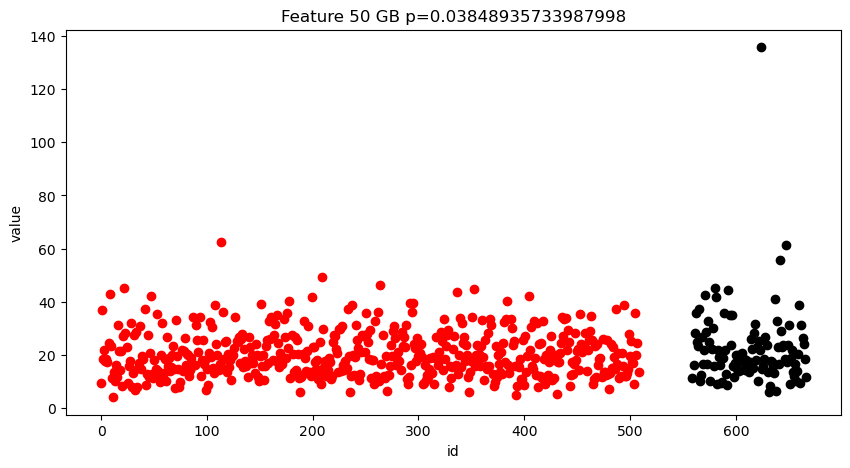

In [12]:
# helpful functions

# plot variable function

def plot_var(featureInd, dataset_df, FEATURE_COLUMNS):

    thisFeatureClass0=dataset_df[FEATURE_COLUMNS[featureInd]][class0_inds]
    thisFeatureClass1=dataset_df[FEATURE_COLUMNS[featureInd]][class1_inds]

    params=sp.stats.ttest_ind(thisFeatureClass0,thisFeatureClass1)

    WIDTH_SIZE=10;
    HEIGHT_SIZE=5;
    plot_buffer=50;

    fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))

    class0_plot_inds=range(0,len(class0_inds))
    class1_plot_inds=range(len(class0_inds)+plot_buffer,len(class0_inds)+plot_buffer+len(class1_inds))

    axs.plot(class0_plot_inds,thisFeatureClass0,'ro')
    axs.plot(class1_plot_inds,thisFeatureClass1,'ko')
    axs.set_xlabel('id')
    axs.set_title('Feature {0} {1} p={2}'.format(featureInd,FEATURE_COLUMNS[featureInd],params.pvalue))
    axs.set_ylabel('value');
    
    return fig

plot_var(50, dataset_df,FEATURE_COLUMNS);